
# Fourier features to capture seasonality
Feature Engineering for Time Series Forecasting

In this notebook we will show how to create fourier features and how we can add them to our forecasting pipeline.

In [1]:
import datetime
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_context("talk")


## Data set synopsis
We will use the Victoria electricity demand dataset found here: https://github.com/tidyverts/tsibbledata/tree/master/data-raw/vic_elec. This dataset is used in the original MSTL paper [1]. It is the total electricity demand at a half hourly granularity for the state of Victora in Australia from 2002 to the start of 2015. A more detailed description of the dataset can be found here.

We resampled the dataset to hourly in the 4th data preparation notebook in the "01-Create-Datasets" folder in this repo. For instructions on how to download, prepare, and store the dataset, refer to notebook number 4, in the folder "01-Create-Datasets" from this repo.

## References
[1] K. Bandura, R.J. Hyndman, and C. Bergmeir (2021) MSTL: A Seasonal-Trend Decomposition Algorithm for Time Series with Multiple Seasonal Patterns. arXiv preprint arXiv:2107.13462.

## Load data

In [2]:
data = pd.read_csv('../datasets/victoria_electricity_demand.csv',
                   usecols=['demand', 'date_time'],
                   parse_dates=['date_time'],
                   index_col=['date_time'],)

In [3]:
data.shape

(115368, 1)

## Plot the data

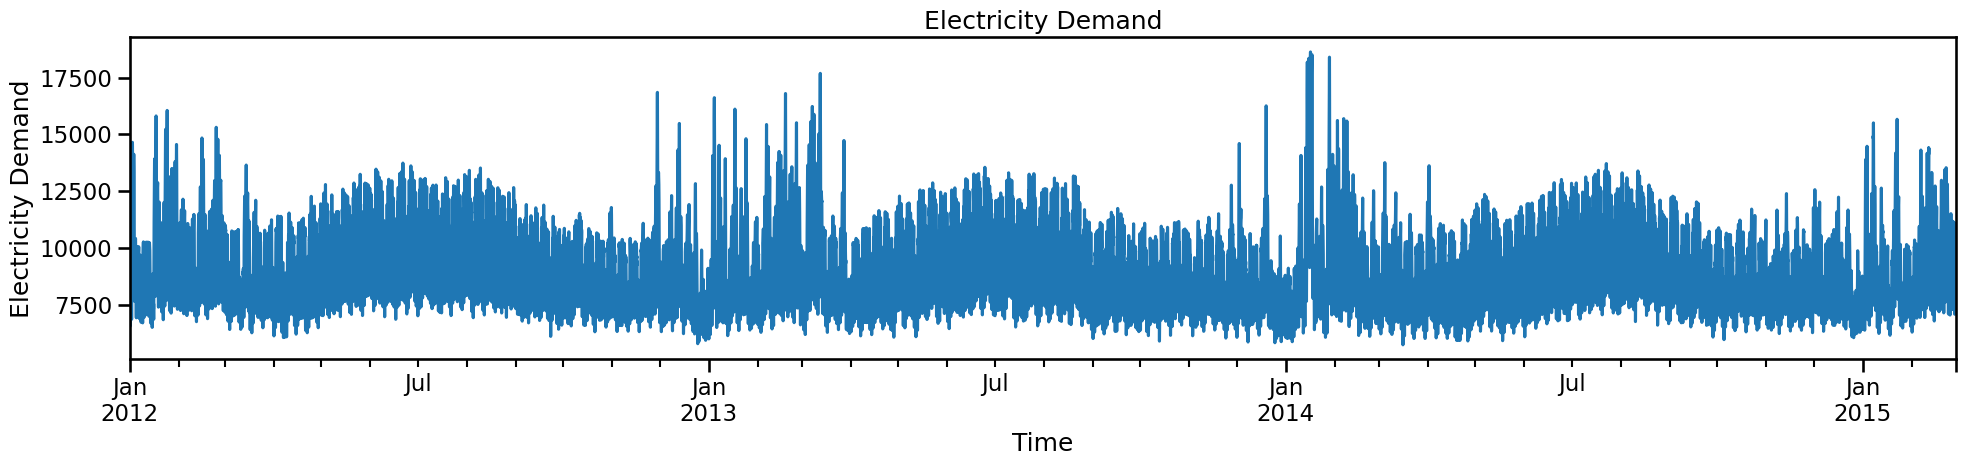

In [4]:
fig, ax = plt.subplots(figsize=(20, 5))

data.loc['2012':].plot(y='demand', legend=None, ax=ax)
ax.set_xlabel('Time')
ax.set_ylabel('Electricity Demand')
ax.set_title('Electricity Demand')
plt.tight_layout()

In [5]:
data.shape

(115368, 1)

## Creating Fourier features with sktime

In [6]:
from sktime.transformations.series.fourier import FourierFeatures

In [7]:
transformer = FourierFeatures(
    sp_list=[24, 24*7],     # list of seasonal periods
    fourier_terms_list=[3, 3],      # list of fourier terms
    freq='H',
    keep_original_columns=False
)

transformer.fit(data)
result = transformer.transform(data)
result.head()

c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\transformations\series\fourier.py:221: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = time_index.to_period(self.freq_)
c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\transformations\series\fourier.py:250: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = X.index.to_period(self.freq_)


,sin_24_1,cos_24_1,sin_24_2,cos_24_2,sin_24_3,cos_24_3,sin_168_1,cos_168_1,sin_168_2,cos_168_2,sin_168_3,cos_168_3
date_time,,,,,,,,,,,,
2002-01-01 00:00:00,0.000000,1.000000,0.000000,1.000000e+00,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2002-01-01 01:00:00,0.258819,0.965926,0.500000,8.660254e-01,7.071068e-01,7.071068e-01,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712
2002-01-01 02:00:00,0.500000,0.866025,0.866025,5.000000e-01,1.000000e+00,6.123234e-17,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928
2002-01-01 03:00:00,0.707107,0.707107,1.000000,6.123234e-17,7.071068e-01,-7.071068e-01,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883
2002-01-01 04:00:00,0.866025,0.500000,0.866025,-5.000000e-01,1.224647e-16,-1.000000e+00,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969


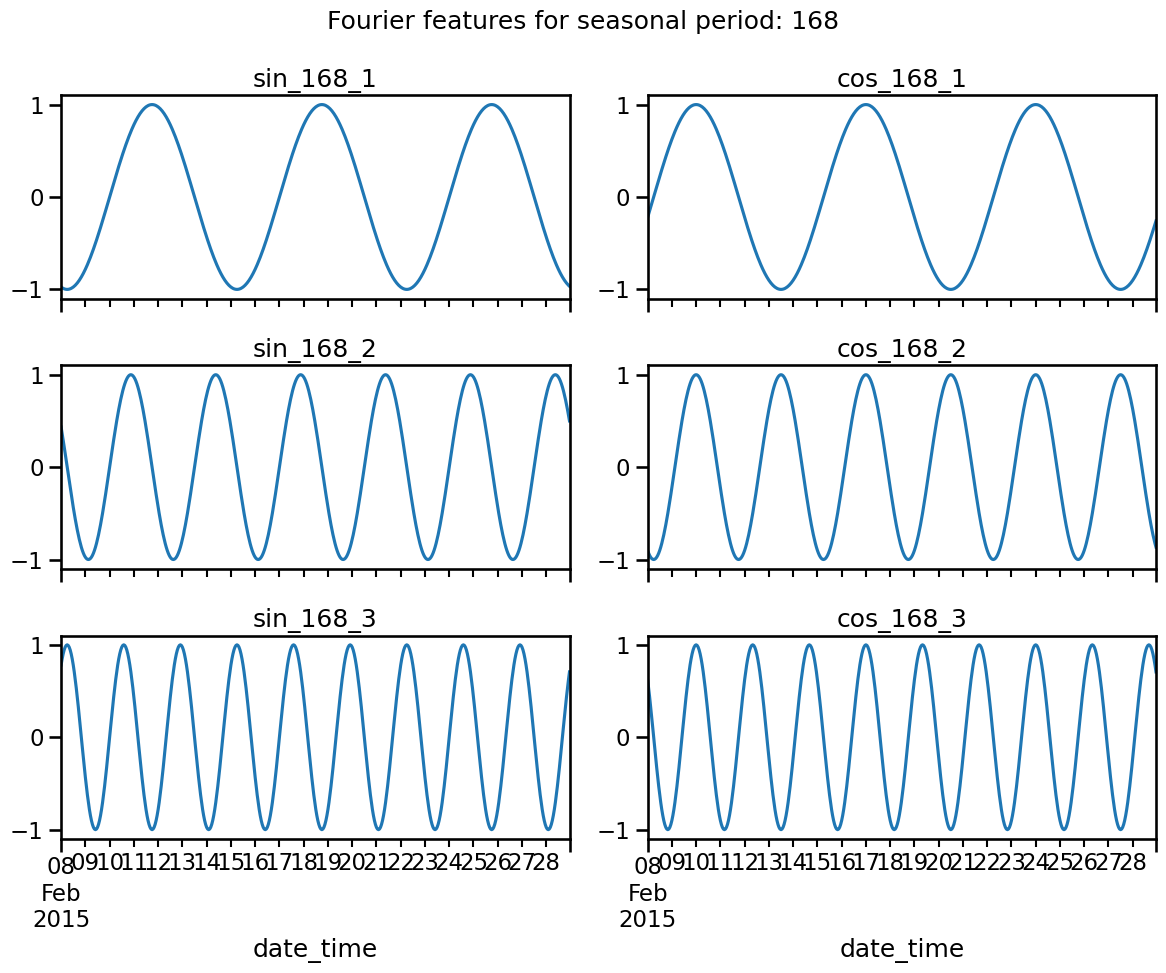

In [8]:
# let's filter to the weekly seasonality of Fourier features
seasonal_period = 24*7
result_ = result.filter(like=f'_{seasonal_period}_').iloc[-seasonal_period*3:]

# plot each fourier feature associated to the specified seasonality
num_features = result_.shape[1]
fig, ax = plt.subplots(nrows=num_features//2, ncols=2, figsize=(12, 10), sharex=True)
for feature, ax in zip(result_.columns, ax.flatten()):
    result_.loc[:, feature].plot(ax=ax)
    ax.set_title(feature)

fig.suptitle(f"Fourier features for seasonal period: {seasonal_period}", fontsize=18)
plt.tight_layout()

We have sine and cosine waves with frequencies which are integer multiples of `seasonal_period`. The number of features is equivalent to the number of `fourier_terms * 2`, the factor of 2 comes from the fact the we have both a sine and cosine wave associated with each frequency.

## Let's see how fourier features help capture seasonality
Let's build a linear model using only fourier features to understand how they help capture seasonality. In a linear model we have:
$$y_t = \beta_0 + \beta_1x_1 +...+ \beta_Nx_N$$
where $N$ is the number of features.

For this dataset we want to model daily and weekly seasonality alongside other features $x_i$. Effectively we want to fit a model that looks like the following:
$$y_t = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + S_t^{daily} + S_t^{weekly}$$
where $S_t^{daily}$ and $S_t^{weekly}$ represent the daily and weekly seasonal component. As discussed in lectures, when using fourier features we are modeling each of these seasonal components using a sum of sine and cosine functions which have frequencies that are integer multiples of the seasonal period:
$$S^{daily}_t = \sum_{n=1}^{n_{daily}} A_{n}^{daily}sin(\frac{2\pi nt}{24}) + B_{n}^{daily}cos(\frac{2\pi nt }{24})$$
$$S^{weekly}_t = \sum_{n=1}^{n_{weekly}} A_{n}^{weekly}sin(\frac{2\pi nt}{24*7}) + B_{n}^{weekly}cos(\frac{2\pi nt }{24*7})$$
where $A_n$ and $B_n$ are the coefficients (i.e., they are just additional $\beta$ coefficients corresponding to the sine and cosine features in the linear model) learned when we train the linear model, $n_{daily}$ & $n_{weekly}$ are hyperparameters which represents the number of sine and cosine features we want to use to model the respective seasonal component.

If we are only using fourier features, the linear model that we are effectively fitting is:
$$\begin{aligned}
y_t &= \sum_{p}\sum_{n=1}^{n_p} A_{n,p}sin(\frac{2\pi nt}{T_p}) + B_{n,p}cos(\frac{2\pi nt }{T_p}) \\
&= \sum_{n=1}^{n_{daily}} A_{n}^{daily}sin(\frac{2\pi nt}{24}) + B_{n}^{daily}cos(\frac{2\pi nt }{24}) +  \sum_{n=1}^{n_{weekly}} A_{n}^{weekly}sin(\frac{2\pi nt}{24*7}) + B_{n}^{weekly}cos(\frac{2\pi nt }{24*7})
\end{aligned}$$
where $p$ represents the seasonality we are modeling


In [9]:
from sklearn.linear_model import LinearRegression

In [10]:
df = data.copy()

df.head()

,demand
date_time,
2002-01-01 00:00:00,6919.366092
2002-01-01 01:00:00,7165.974188
2002-01-01 02:00:00,6406.542994
2002-01-01 03:00:00,5815.537828
2002-01-01 04:00:00,5497.732922


In [11]:
fourier_feats = FourierFeatures(
    sp_list=[
        24,     # daily seasonality
        24*7,   # weekly seasonality
        24*365, # yearly seasonality
    ],
    # the number of fourier components for each seasonality
    fourier_terms_list=[
        3,  # daily seasonality
        3,  # weekly seasonality
        3,  # yearly seasonality
    ],
    freq='H',
    keep_original_columns=False,
)

In [12]:
# split data into train and test
# hold out the last 2 weeks of observations
hold_out_size = 24*7*2
df_train = data.iloc[:-hold_out_size]
df_test = data.iloc[-hold_out_size:]

In [13]:
# create fourier features
target = ['demand']

X_train = fourier_feats.fit_transform(df_train)
y_train = df_train.loc[:, target]

X_test = fourier_feats.transform(df_test)
y_test = df_test.loc[:, target]

c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\transformations\series\fourier.py:221: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = time_index.to_period(self.freq_)
c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\transformations\series\fourier.py:250: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = X.index.to_period(self.freq_)
c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\transformations\series\fourier.py:250: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = X.index.to_period(self.freq_)


We have the fourier features for both the training and testing period. So we can use these to directly predict the entire test period without having to use direct or recursive forecasting. We show later in this notebook how to use fourier features alongside other features which requires us to use a direct or recursive forecasting workflow to do multistep forecasting.

In [14]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [15]:
y_forecast_train = model.predict(X_train)
y_forecast_train = pd.DataFrame(y_forecast_train, index=X_train.index, columns=target)

y_forecast_test = model.predict(X_test)
y_forecast_test = pd.DataFrame(y_forecast_test, index=X_test.index, columns=target)

Text(0.5, 1.0, 'Forecast with LinearRegression()')

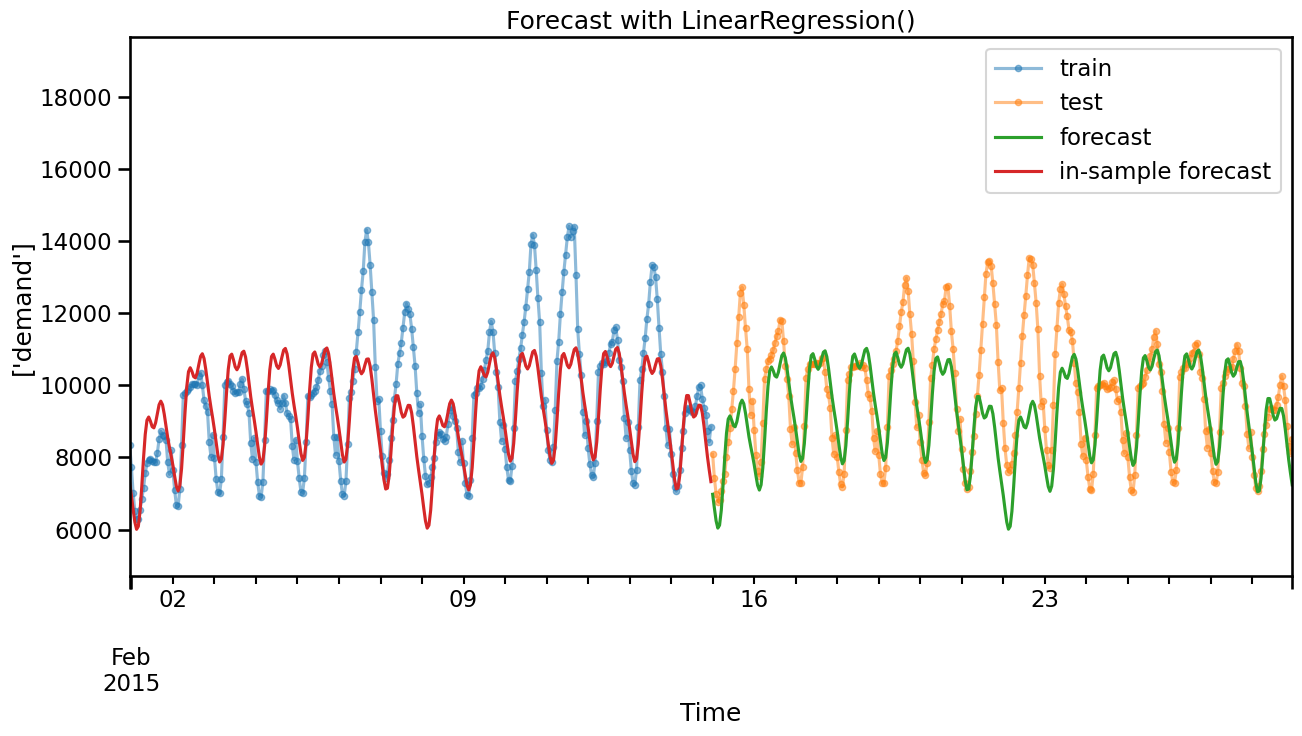

In [16]:

# --- PLOTTING --- #
# Plot the forecast.
fig, ax = plt.subplots(figsize=[15, 7])

# Plot training set.
y_train.plot(ax=ax, marker=".", alpha=0.5)
# Plot actuals in forecasting horizon.
y_test.plot(ax=ax, marker=".", alpha=0.5)
# Plot forecast in testing data.
y_forecast_test.plot(ax=ax)
# Plot forecasts in training data.
y_forecast_train.plot(ax=ax)

ax.legend(["train", "test", "forecast", "in-sample forecast"])
ax.set_xlim(xmin=y_train.index.max() - pd.DateOffset(weeks=2))
ax.set_xlabel("Time")
ax.set_ylabel(f"{target}")
ax.set_title(f"Forecast with {model}")


We can see that just using Fourier features we are able to capture daily and weekly seasonality. In the absence of other features the forecast is completely periodic; this is expected because the model is just a sum of sine and cosine functions.

Try adjusting the number of Fourier terms in the `fourier_terms_list` argument and see how it changes the predictions.

Let's add more features alongside Fourier features and build a forecast!

## Build some forecasts

In [ ]:
from sktime.transformations.series.fourier import FourierFeatures
from sktime.transformations.series.date import DateTimeFeatures
from sklearn.preprocessing import OneHotEncoder
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.time_since import TimeSince
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline, make_union
from sklearn.base import clone


from sklearn import set_config
set_config(transform_output="pandas")

In [18]:
df = data.copy()
df.head()

,demand
date_time,
2002-01-01 00:00:00,6919.366092
2002-01-01 01:00:00,7165.974188
2002-01-01 02:00:00,6406.542994
2002-01-01 03:00:00,5815.537828
2002-01-01 04:00:00,5497.732922


In [19]:
target = ['demand']

In [20]:
# prepare our transformers
time_feats = make_pipeline(
    TimeSince(),
    PolynomialFeatures(degree=1, include_bias=False)
)

datetime_features = [
    'is_weekend',
]

datetime_feats = DateTimeFeatures(
    manual_selection=datetime_features,
    keep_original_columns=False,
)

fourier_feats = FourierFeatures(
    sp_list=[24, 24*7],
    fourier_terms_list=[3, 3],
    freq='H',
    keep_original_columns=False
)

lag_window_feats = WindowSummarizer(
    lag_feature={
        'lag': [1,2,3,4],
        # "mean": [[1, 24], [1, 24 * 7]],
    },
    target_cols=target,
    truncate='bfill'
)

c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\transformations\series\date.py:448: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  DUMMIES = DUMMIES.replace(


In [21]:
# create a pipeline
pipeline = make_union(
    datetime_feats,
    fourier_feats,
    time_feats,
    lag_window_feats,
)

# Apply min-max scaling to all the features
pipeline = make_pipeline(pipeline, MinMaxScaler())

In [22]:
pipeline

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('datetimefeatures',
                                                 DateTimeFeatures(manual_selection=['is_weekend'])),
                                                ('fourierfeatures',
                                                 FourierFeatures(fourier_terms_list=[3, 3], freq='H', sp_list=[24, 168])),
                                                ('pipeline',
                                                 Pipeline(steps=[('timesince',
                                                                  TimeSince()),
                                                                 ('polynomialfeatures',
                                                                  PolynomialFeatures(degree=1,
                                                                                     include_bias=False))])),
                                                ('windowsummarizer',
                                                 WindowSummarizer(lag_feature={'lag': [1, 2, 3, 4]}, target_cols=['demand'],
                 truncate='bfill'))])),
                ('minmaxscaler', MinMaxScaler())])

In [23]:
pipeline.fit_transform(df.head())

c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\transformations\series\date.py:448: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  DUMMIES = DUMMIES.replace(
c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\transformations\series\fourier.py:221: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = time_index.to_period(self.freq_)
c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\transformations\series\fourier.py:250: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = X.index.to_period(self.freq_)
c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\skti

,is_weekend,sin_24_1,cos_24_1,sin_24_2,cos_24_2,sin_24_3,cos_24_3,sin_168_1,cos_168_1,sin_168_2,cos_168_2,sin_168_3,cos_168_3,time_since_2002-01-01 00:00:00,demand_lag_1,demand_lag_2,demand_lag_3,demand_lag_4
date_time,,,,,,,,,,,,,,,,,,
2002-01-01 00:00:00,0.0,0.000000,1.000000,0.000000,1.000000,0.000000e+00,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00,0.817386,0.675273,0.0,0.0
2002-01-01 01:00:00,0.0,0.298858,0.931852,0.500000,0.910684,7.071068e-01,0.853553,0.250876,0.937391,0.253533,0.937061,0.258052,0.936507,0.25,0.817386,0.675273,0.0,0.0
2002-01-01 02:00:00,0.0,0.577350,0.732051,0.866025,0.666667,1.000000e+00,0.500000,0.501402,0.749650,0.505648,0.748596,0.512858,0.746826,0.50,1.000000,0.675273,0.0,0.0
2002-01-01 03:00:00,0.0,0.816497,0.414214,1.000000,0.333333,7.071068e-01,0.146447,0.751226,0.437041,0.754935,0.435659,0.761216,0.433343,0.75,0.437640,1.000000,0.0,0.0
2002-01-01 04:00:00,0.0,1.000000,0.000000,0.866025,0.000000,1.224647e-16,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.00,0.000000,0.000000,1.0,0.0


In [24]:
# We can use `clone` to return an unfitted version
# of the pipeline.
pipeline = clone(pipeline)

c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\transformations\series\date.py:448: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  DUMMIES = DUMMIES.replace(


Let's build a recursive forecast

In [25]:
from lightgbm import LGBMRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge

In [26]:
# CONFIG
forecast_start_time = df.index.max() - pd.DateOffset(weeks=2)

# define number of steps to forecast
num_of_forecast_steps = 24*14

# define the model
model = LinearRegression()

# create a list of periods that we will forecast over
forecast_horizon = pd.date_range(
    start=forecast_start_time,
    periods=num_of_forecast_steps,
    freq='H'
)

# how much data in the past is needed to create our features
look_back_window_size = pd.DateOffset(weeks=1)

C:\Users\Asus\AppData\Local\Temp\ipykernel_21260\3329548654.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_horizon = pd.date_range(


In [27]:
# CREATE TRAINING AND TESTING DATAFRAME
df_train = df.loc[df.index < forecast_start_time].copy()
df_test = df.loc[df.index >= forecast_start_time].copy()

In [28]:
# FEATURE ENGINEERING
# create X_train and y_train
y_train = df_train[target]
X_train = pipeline.fit_transform(df_train)

# LightGBM cannot handle column names which havve certain characters
# we replace these with _
if 'lightgbm' in model.__module__:
    X_train = X_train.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "_", x))

c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\transformations\series\date.py:448: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  DUMMIES = DUMMIES.replace(
c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\transformations\series\fourier.py:221: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = time_index.to_period(self.freq_)
c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\transformations\series\fourier.py:250: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = X.index.to_period(self.freq_)
c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\skti

In [29]:
# MODEL TRAINING
# train one-step ahead forecast model
model.fit(X_train, y_train)

LinearRegression()

In [30]:
# CREATE DYNAMIC PREDICTION DATAFRAME
# We will recursively append our forecasts to this 
# dataframe and re-compute our lag and window features from the
# target in this dataframe. It contains data in both the training period 
# and forecast period which is needed for some transformers (e.g., lags and windows).
look_back_start_time = forecast_start_time - look_back_window_size

# create `df_predict` which has data going as far back as needed
# to create features which need past values
df_predict = df_train.loc[look_back_start_time:].copy()

# extend index into forecast horizon
df_predict = pd.concat(
    [df_predict, pd.DataFrame(index=forecast_horizon)]
)

In [31]:
# RECURSIVE FORECASTING LOOP
for forecast_time in forecast_horizon:
    # compute features during forecast horizon
    X_test = pipeline.transform(df_predict)
    X_test = X_test.loc[[forecast_time]]

    # predict one step ahead
    y_pred = model.predict(X_test)

    # append forecast to the target variable column in `df_predict`
    # this `df_predict` is ready for the next iteration where we will 
    # recompute features derived from the target such as lags and windows
    df_predict.loc[[forecast_time], target] = y_pred

c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\transformations\series\fourier.py:250: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = X.index.to_period(self.freq_)
c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\transformations\series\fourier.py:250: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = X.index.to_period(self.freq_)
c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\transformations\series\fourier.py:250: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = X.index.to_period(self.freq_)
c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\transformations\series\fourier.py:250: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  tim

In [32]:
# GET FORECAST AND TEST VALUES
y_forecast = df_predict.loc[forecast_horizon, target]
y_test = df_test.loc[forecast_start_time:, target]

In [33]:
# CREATE IN-SAMPLE PREDICTIONS
y_forecast_train = model.predict(X_train)
y_forecast_train = pd.DataFrame(y_forecast_train, index=X_train.index, columns=target)

Text(0.5, 1.0, 'Recursive forecast with LinearRegression()')

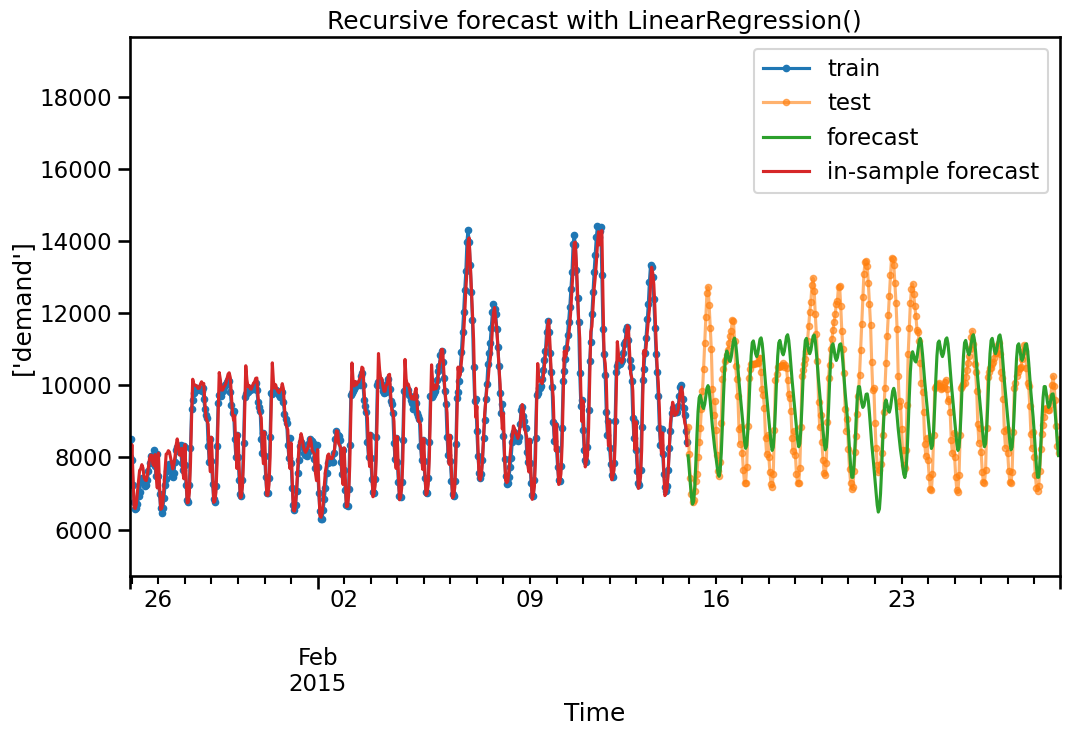

In [34]:
# PLOTTING
# Plot the forecast.
fig, ax = plt.subplots(figsize=[12, 7])

# Plot training set.
y_train.plot(ax=ax, marker='.')
# Plot actuals in forecasting horizon.
y_test.plot(ax=ax, marker='.', alpha=0.6)
# Plot forecast.
y_forecast.plot(ax=ax)
# Plot 1 step forecasts in training data.
y_forecast_train.plot(ax=ax)

ax.legend(["train", "test", "forecast", "in-sample forecast"])
ax.set_xlim(xmin=y_train.index.max() - pd.DateOffset(weeks=3))
ax.set_xlabel("Time")
ax.set_ylabel(f"{target}")
ax.set_title(f"Recursive forecast with {model}")

In [35]:
# compute RMSE
from sklearn.metrics import root_mean_squared_error

root_mean_squared_error(y_true=y_test.loc[y_forecast.index],
                        y_pred=y_forecast)

1189.4848395594388